# USD/THB Feature Engineering Notebook

Goal: explore FX features, understand distributions, and build engineered features (lags, rolling stats, returns) for the USD/THB 30-day ahead forecasting project.


In [1]:
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import project_paths  # noqa: F401
from database.save_db import get_engine
from models.train_xgboost import load_data, create_features

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline


## 1. Data Loading & Overview


In [2]:
# Load data from PostgreSQL
print("📥 Loading data from PostgreSQL database...")
df = load_data(start_date='2020-01-01')

print(f"\n✅ Dataset shape: {df.shape}")
print(f"📅 Date range: {df.index.min()} to {df.index.max()}")
print(f"📊 Total days: {len(df)}")
print(f"\n📋 Columns: {list(df.columns)}")

df.head()


📥 Loading data from PostgreSQL database...
✅ Loaded 2152 rows from database

✅ Dataset shape: (2152, 14)
📅 Date range: 2020-01-01 00:00:00 to 2025-11-21 00:00:00
📊 Total days: 2152

📋 Columns: ['usd_thb', 'dxy', 'gold', 'oil', 'vix', 'sp500', 'set_index', 'th_10y', 'th_cpi', 'th_policy_rate', 'us_10y', 'us_cpi', 'us_fed_rate', 'news_sentiment']


,usd_thb,dxy,gold,oil,vix,sp500,set_index,th_10y,th_cpi,th_policy_rate,us_10y,us_cpi,us_fed_rate,news_sentiment
date,,,,,,,,,,,,,,
2020-01-01,29.680000,96.849998,1524.500000,61.180000,12.47,3257.850098,1595.819946,1.460,1.05,1.25,1.88,259.127,1.55,959.0
2020-01-02,30.059999,96.849998,1524.500000,61.180000,12.47,3257.850098,1595.819946,1.460,1.05,1.25,1.88,259.127,1.55,1416.0
2020-01-03,30.139999,96.839996,1549.199951,63.049999,14.02,3234.850098,1594.969971,1.435,1.05,1.25,1.80,259.127,1.55,1639.0
2020-01-04,30.139999,96.839996,1549.199951,63.049999,14.02,3234.850098,1594.969971,1.435,1.05,1.25,1.80,259.127,1.55,733.0
2020-01-05,30.139999,96.839996,1549.199951,63.049999,14.02,3234.850098,1594.969971,1.435,1.05,1.25,1.80,259.127,1.55,559.0


In [3]:
# Descriptive statistics
df.describe()


,usd_thb,dxy,gold,oil,vix,sp500,set_index,th_10y,th_cpi,th_policy_rate,us_10y,us_cpi,us_fed_rate,news_sentiment
count,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000
mean,33.561302,100.150502,2151.812311,70.230237,20.959633,4543.156575,1453.681147,2.113754,1.384526,1.343053,2.936055,293.252416,2.737937,1402.206784
std,1.952824,5.521410,579.564422,18.737683,7.833212,988.634956,159.558817,0.596993,2.580433,0.802441,1.410244,22.686021,2.233628,982.142734
min,29.680000,89.440002,1477.300049,-37.630001,11.860000,2237.399902,1024.459961,0.860000,-3.440000,0.500000,0.520000,255.802000,0.050000,0.000000
25%,32.270000,96.037500,1793.649963,61.900000,15.887500,3900.860107,1328.530029,1.570000,-0.470000,0.500000,1.530000,270.710000,0.090000,698.500000
50%,33.520000,100.860001,1918.000000,71.809998,19.080000,4369.709961,1469.589966,2.200000,0.620000,1.250000,3.530000,298.808000,4.090000,1133.000000
75%,34.987000,104.279999,2340.950012,80.277502,24.120000,5282.700195,1592.152466,2.570000,2.670000,2.250000,4.220000,313.140000,4.830000,1950.250000
max,38.299999,114.110001,4336.399902,123.699997,82.690002,6890.890137,1713.199951,3.390000,7.860000,2.500000,4.980000,324.368000,5.330000,12829.000000


In [4]:
# Missing values analysis
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')
    plt.title('Missing Values by Feature', fontsize=14, fontweight='bold')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('✅ No missing values!')


✅ No missing values!


## 2. Exploratory Data Analysis


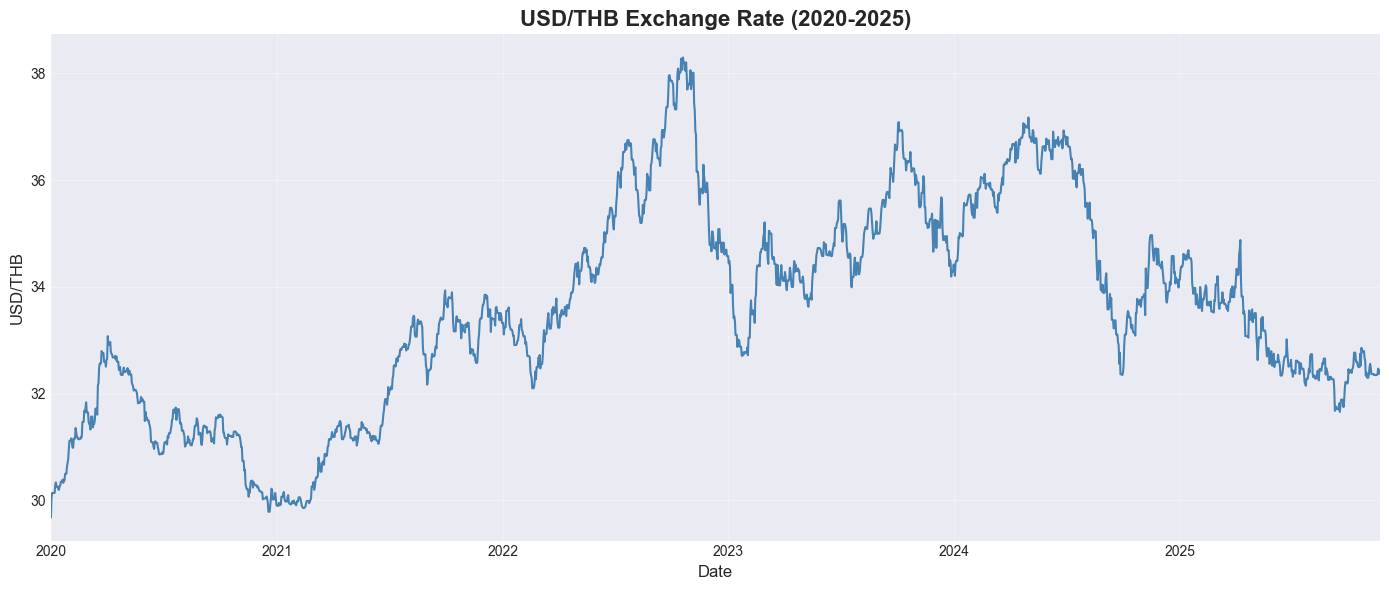


💵 Latest USD/THB rate: 32.4400 (as of 2025-11-21)


In [5]:
# USD/THB time series
fig, ax = plt.subplots(figsize=(14, 6))
df['usd_thb'].plot(ax=ax, linewidth=1.5, color='steelblue')
ax.set_title('USD/THB Exchange Rate (2020-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('USD/THB', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

latest_rate = df['usd_thb'].iloc[-1]
latest_date = df.index[-1]
print(f"\n💵 Latest USD/THB rate: {latest_rate:.4f} (as of {latest_date.date()})")


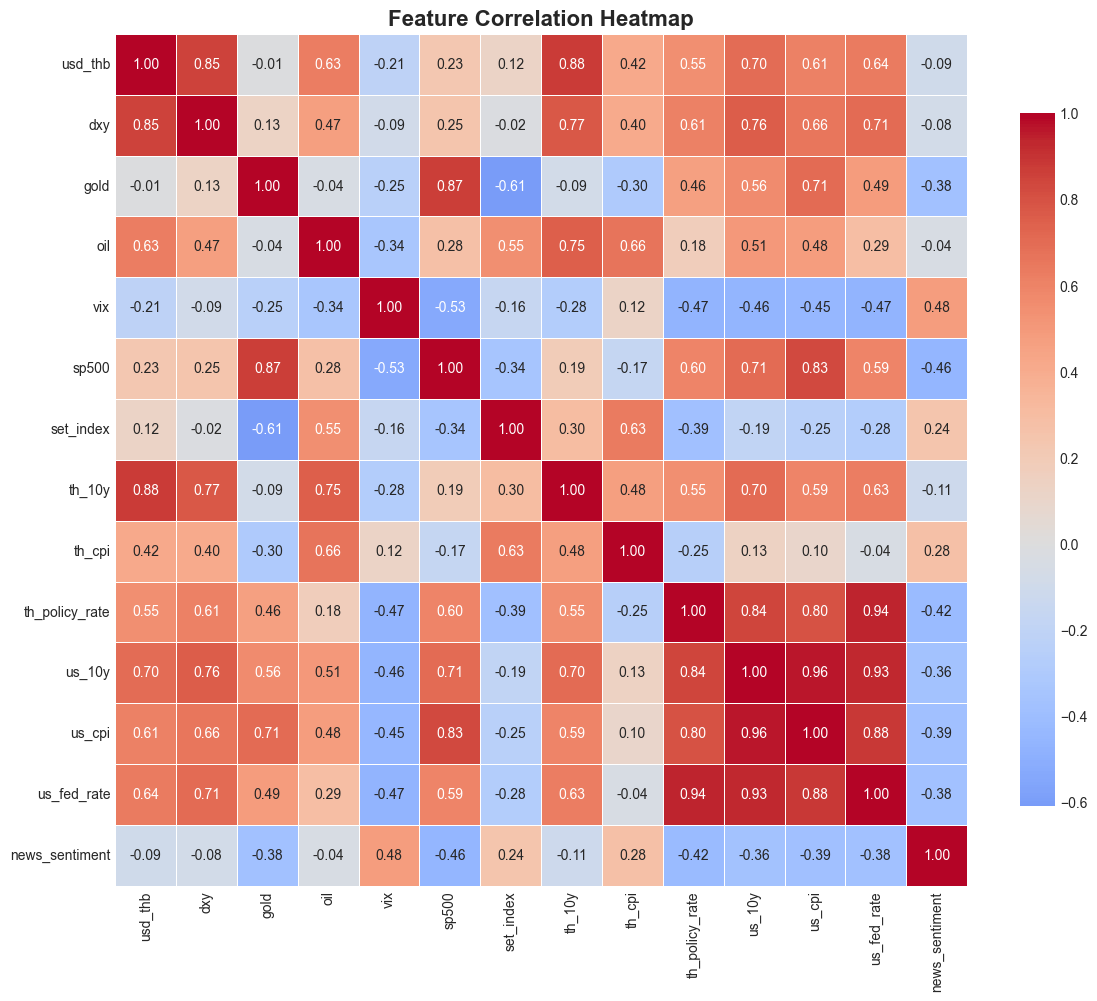

In [6]:
# Correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


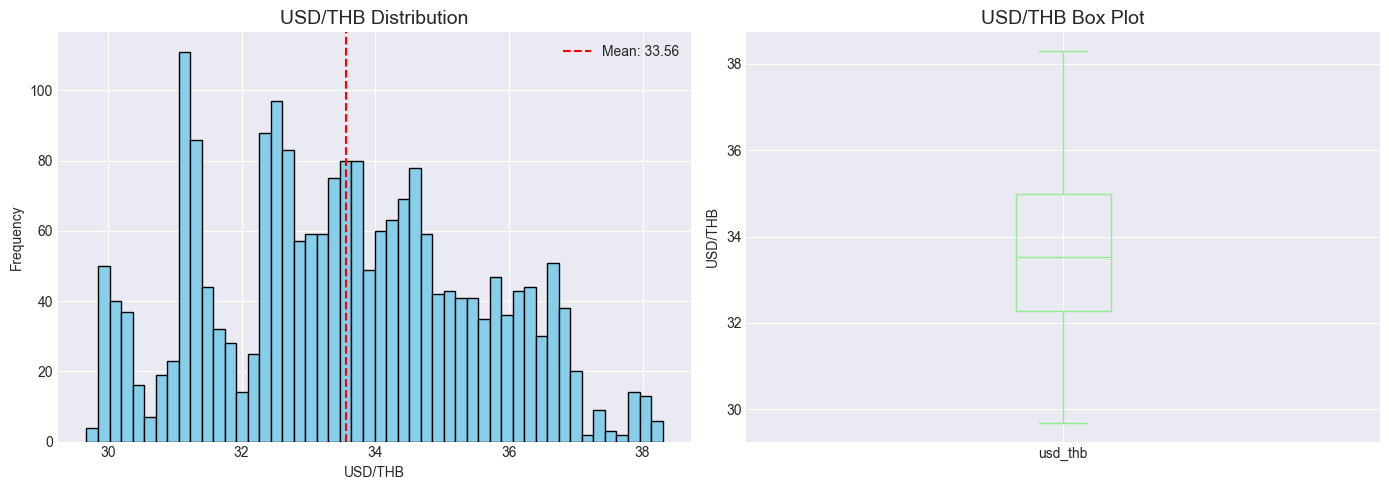

In [7]:
# USD/THB distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['usd_thb'].hist(bins=50, ax=axes[0], edgecolor='black', color='skyblue')
axes[0].set_title('USD/THB Distribution', fontsize=14)
axes[0].set_xlabel('USD/THB')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['usd_thb'].mean(), color='red', linestyle='--', label=f"Mean: {df['usd_thb'].mean():.2f}")
axes[0].legend()

df['usd_thb'].plot(kind='box', ax=axes[1], color='lightgreen')
axes[1].set_title('USD/THB Box Plot', fontsize=14)
axes[1].set_ylabel('USD/THB')

plt.tight_layout()
plt.show()


## 3. Feature Engineering


In [8]:
# Create engineered features
print("🔧 Creating features (lags, rolling stats, returns)...")
df_features = create_features(df, target_shift=30)

print(f"\n✅ Features created: {len(df_features.columns)}")
print(f"📊 Rows after feature engineering: {len(df_features)}")
print(f"🗑️ Rows dropped (due to 30-day forecast shift): {len(df) - len(df_features)}")


🔧 Creating features (lags, rolling stats, returns)...
✅ Created 67 features
   Rows after target creation: 2122

✅ Features created: 67
📊 Rows after feature engineering: 2122
🗑️ Rows dropped (due to 30-day forecast shift): 30


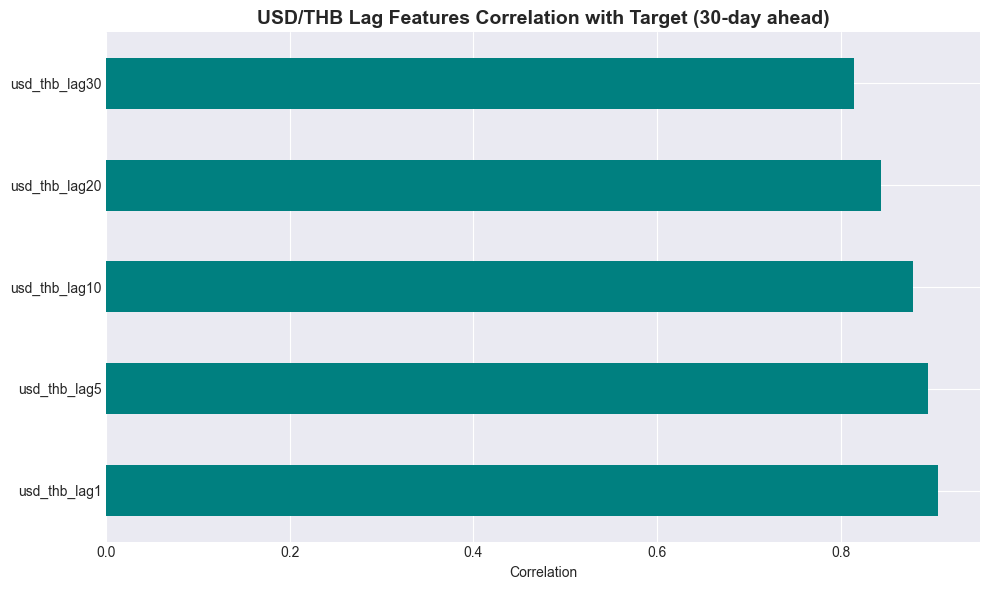

In [9]:
# Lag feature correlation with target
lag_cols = [col for col in df_features.columns if 'lag' in col and 'usd_thb' in col]
lag_corr = df_features[lag_cols + ['target']].corr()['target'].drop('target').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
lag_corr.plot(kind='barh', color='teal')
plt.title('USD/THB Lag Features Correlation with Target (30-day ahead)', fontsize=14, fontweight='bold')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()
